Unzipping file...
admissions loaded successfully.
patients loaded successfully.
callout loaded successfully.
icustays loaded successfully.
drgcodes loaded successfully.
services loaded successfully.
['row_id_patient', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id_admission', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'row_id_callout', 'submit_wardid', 'submit_careunit', 'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service', 'request_tele', 'request_resp', 'request_cdiff', 'request_mrsa', 'request_vre', 'callout_status', 'callout_outcome', 'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime', 'acknowledgetime', 'outcometime', 'firstreservationtime', 'currentreservationtime', 'row_id_icustays', 'icust

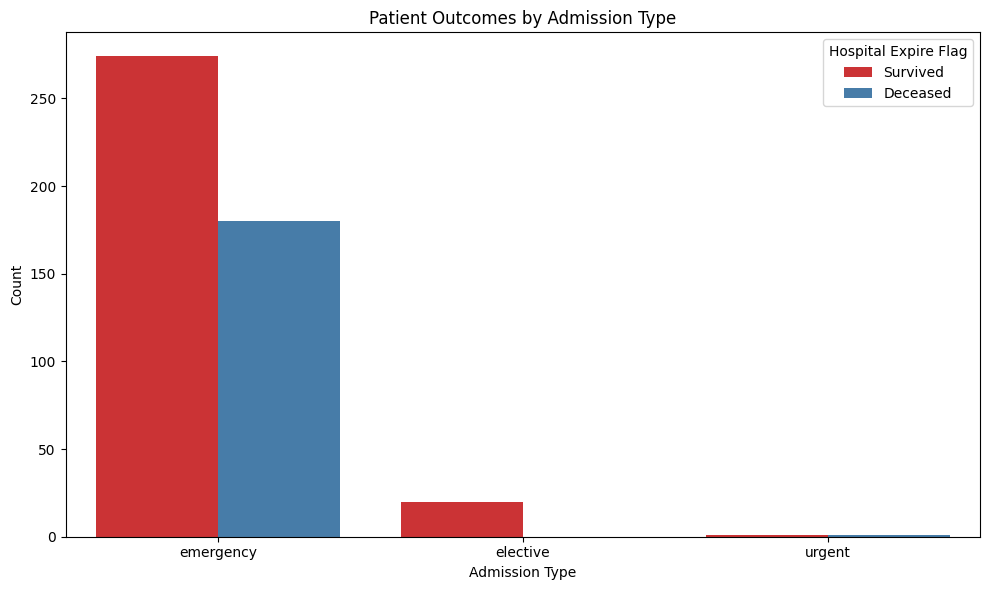

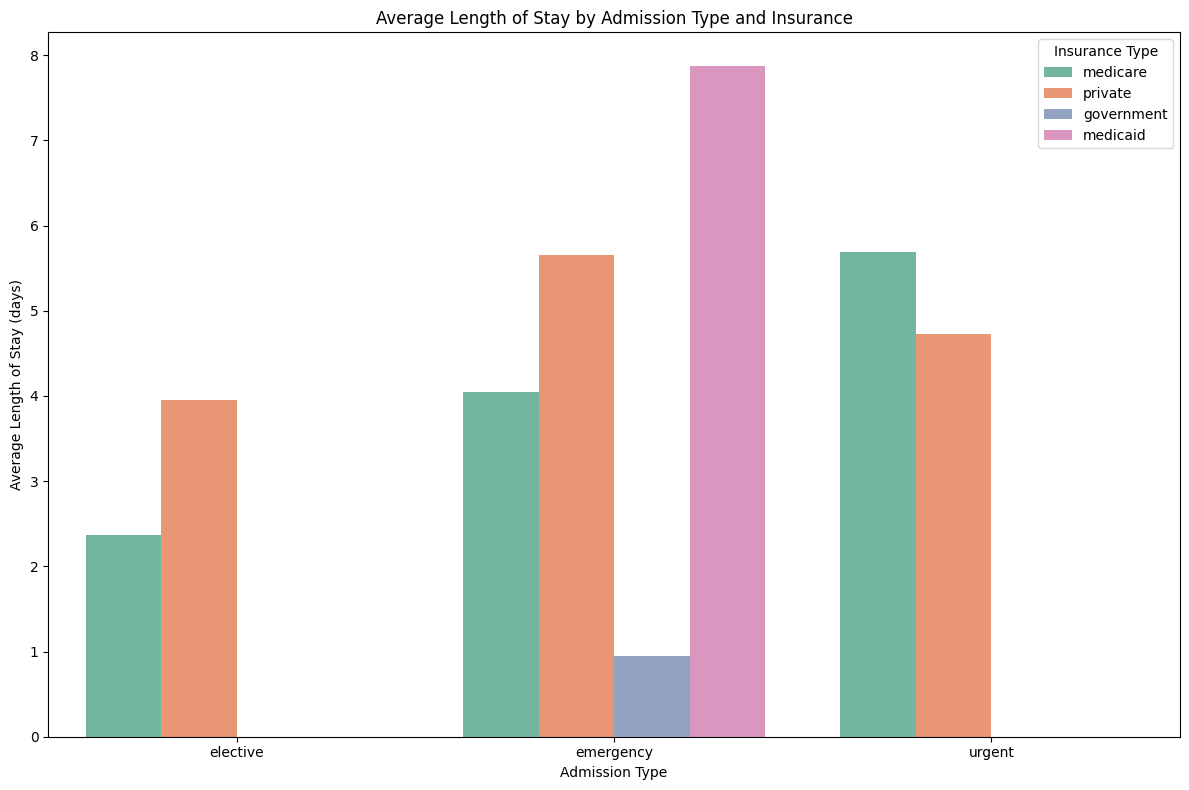

{'accuracy': 0.7832167832167832, 'precision': 0.75, 'recall': 0.5882352941176471, 'f1': 0.6593406593406592, 'roc_auc': 0.8124467178175618, 'confusion_matrix': array([[82, 10],
       [21, 30]])}


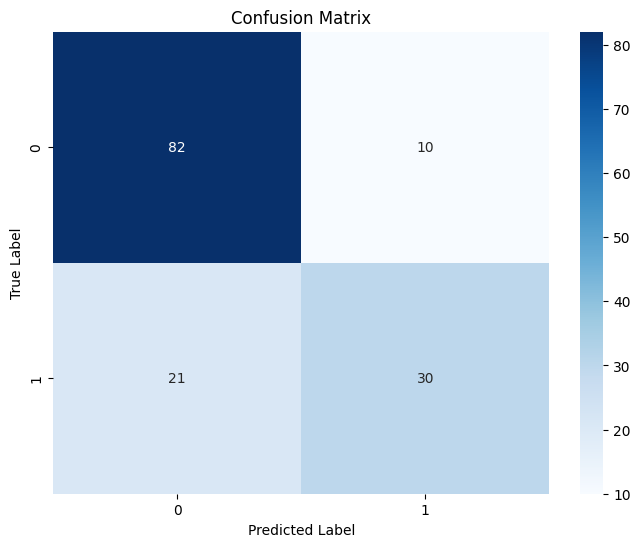

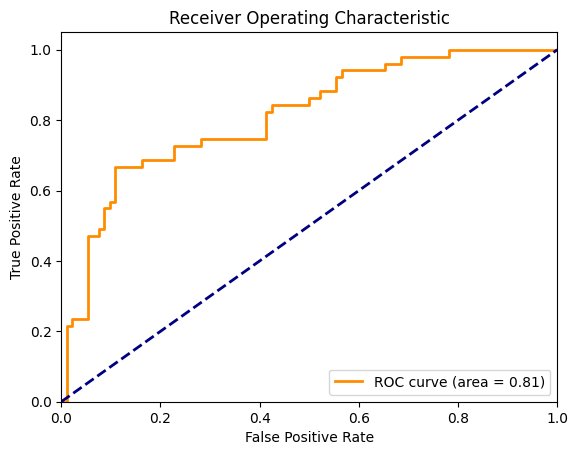

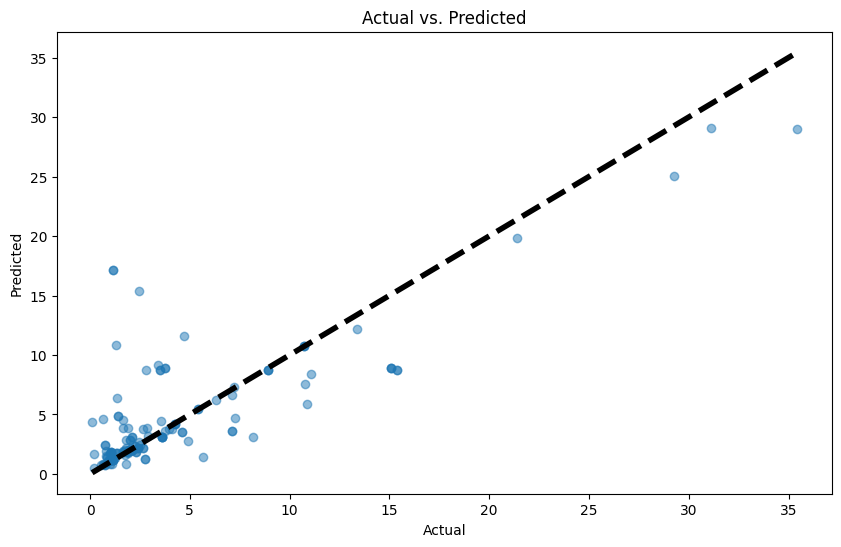

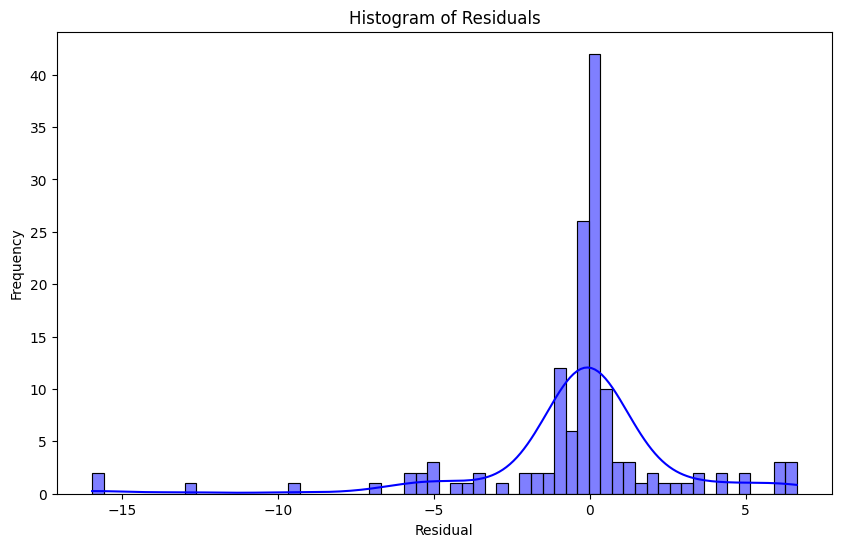

In [ ]:
# Standard library imports
import os
import glob
from io import BytesIO
import datetime
from datetime import date

# Third-party library imports for data handling
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

# Machine learning and model evaluation imports from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    mean_squared_error
)

# Other external libraries
import requests
import zipfile

class DataAcquisition:
    def __init__(self, url):
        """
        Initialize the DataAcquisition with a URL.

        :param url: A string representing the URL from which to download a file.
        """
        self.url = url

    def download_and_extract(self):
        """
        Download a file from the given URL and extract its contents.

        This method downloads a file from the specified URL and assumes it is a zip file.
        It then extracts the contents of the zip file into the current directory.
        """
        print("Downloading file...")
        response = requests.get(self.url)
        response.raise_for_status()
        print("Unzipping file...")
        zip_file = zipfile.ZipFile(BytesIO(response.content))
        zip_file.extractall()


class DataFrameLoader:
    def __init__(self, file_paths):
        """
        Initialize the DataFrameLoader with a dictionary of file paths.

        :param file_paths: A dictionary where keys are identifiers for the
                           dataframes and values are the file paths for the CSV files.
        """
        self.file_paths = file_paths

    def load_dataframes(self):
        """
        Load CSV files into pandas DataFrames.

        :return: A dictionary of pandas DataFrames. Keys match the keys provided
                 in the file_paths dictionary.
        """
        dataframes = {}
        for key, path in self.file_paths.items():
            try:
                dataframes[key] = pd.read_csv(path)
                print(f"{key} loaded successfully.")
            except FileNotFoundError as e:
                print(f"Error loading {key}: {e}")
            except pd.errors.ParserError as e:
                print(f"Error parsing {key}: {e}")
            except Exception as e:
                print(f"Unexpected error loading {key}: {e}")
        return dataframes


class DataPreprocessor:
    def __init__(self, dataframes):
        """
        Initialize the DataPreprocessor with the dataframes to be preprocessed.

        :param dataframes: A dictionary of pandas dataframes to be processed.
        """
        self.dataframes = dataframes

    def preprocess(self):
        """
        Perform the preprocessing steps on the dataframes.

        :return: A processed pandas dataframe.
        """
        # Merge dataframes
        patient_df = self.dataframes['patients']
        admission_df = self.dataframes['admissions']
        icustays_df = self.dataframes['icustays']
        drgcodes_df = self.dataframes['drgcodes']
        services_df = self.dataframes['services']
        callout_df = self.dataframes['callout']

        patient_df = patient_df.merge(admission_df, on="subject_id", how="left", suffixes=('_patient', '_admission')) \
                       .merge(callout_df, on=["subject_id", "hadm_id"], how="left", suffixes=('_admission', '_callout')) \
                       .merge(icustays_df, on=["subject_id", "hadm_id"], how="left", suffixes=('_callout', '_icustays')) \
                       .merge(drgcodes_df, on=["subject_id", "hadm_id"], how="left", suffixes=('_icustays', '_drgcodes')) \
                       .merge(services_df, on=["subject_id", "hadm_id"], how="left", suffixes=('_drgcodes', '_services'))

        # Drop empty and unnecessary columns
        patient_df.dropna(how="all", axis="columns", inplace=True)
        print(patient_df.columns.tolist())


        columns_to_drop = [
            "row_id_x",
            "row_id_y",
            "dod_hosp",
            "dod_ssn",
            "language",
            "religion",
            "marital_status",
            "edregtime",
            "edouttime",
            "diagnosis",
            "has_chartevents_data"
            "submit_wardid",
            "submit_careunit",
            "curr_wardid",
            "curr_careunit",
            "callout_wardid",
            "request_tele",
            "request_resp",
            "request_cdiff",
            "request_mrsa"]
        patient_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

        # Convert columns to lowercase
        patient_df = patient_df.apply(lambda x: x.astype(
            str).str.lower() if x.dtype == "object" else x)

        # Fill 'callout_service' and 'callout_outcome' with mode
        for column in ["callout_service", "callout_outcome"]:
            mode = patient_df[column].mode()[0]
            patient_df[column] = patient_df[column].fillna(mode)

        # Fill 'createtime' and 'outcometime' with 'admittime'
        patient_df["createtime"] = patient_df["createtime"].fillna(
            patient_df["admittime"])
        patient_df["outcometime"] = patient_df["outcometime"].fillna(
            patient_df["admittime"])

        # Fill 'deathtime' with 'dod' for patients not having hospital death
        patient_df["deathtime"] = patient_df["deathtime"].fillna(
            patient_df["dod"])

        return patient_df


class DataVisualizer:
    def __init__(self, dataframe):
        """
        Initialize the DataVisualizer with the dataframe to be visualized.

        :param dataframe: A pandas DataFrame to be used for visualizations.
        """
        self.dataframe = dataframe

    def plot_missing_data(self):
        """
        Plots the percentage of missing data for each column in the dataframe.
        """
        missing_data_ratios = (
            self.dataframe.isnull().sum() / len(self.dataframe)) * 100
        missing_data_ratios = missing_data_ratios[missing_data_ratios > 0].sort_values(
            ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_data_ratios.index, y=missing_data_ratios)
        plt.ylabel('Percentage of Missing Data')
        plt.xlabel('Columns')
        plt.title('Percentage of Missing Data by Column')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_patient_outcomes_by_admission_type(self):
        """
        Plots patient outcomes by admission type.
        """
        plt.figure(figsize=(10, 6))
        sns.countplot(
            x='admission_type',
            hue='hospital_expire_flag',
            data=self.dataframe,
            palette='Set1')
        plt.title('Patient Outcomes by Admission Type')
        plt.xlabel('Admission Type')
        plt.ylabel('Count')
        plt.legend(
            title='Hospital Expire Flag',
            labels=[
                'Survived',
                'Deceased'])
        plt.tight_layout()
        plt.show()

    def plot_average_los_by_admission_and_insurance(self):
        """
        Plots the average length of stay by admission type and insurance.
        """
        grouped_data = self.dataframe.groupby(['admission_type', 'insurance'])[
            'los'].mean().reset_index()

        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='admission_type',
            y='los',
            hue='insurance',
            data=grouped_data,
            palette='Set2')
        plt.title('Average Length of Stay by Admission Type and Insurance')
        plt.xlabel('Admission Type')
        plt.ylabel('Average Length of Stay (days)')
        plt.legend(title='Insurance Type')
        plt.tight_layout()
        plt.show()


class ModelTrainer:
    def __init__(
            self,
            model,
            X,
            y,
            categorical_features,
            numerical_features,
            test_size=0.3,
            random_state=42):
        """
        Initialize the ModelTrainer with a model, dataset, and preprocessing info.

        :param model: The machine learning model to be trained.
        :param X: Feature set.
        :param y: Target variable.
        :param categorical_features: List of names of the categorical features.
        :param numerical_features: List of names of the numerical features.
        :param test_size: Size of the test dataset.
        :param random_state: Seed for the random number generator.
        """
        self.model = model
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        self.pipeline = Pipeline(
            steps=[('preprocessor', self.preprocessor), ('model', model)])

    def train(self):
        """
        Train the model using the training dataset.
        """
        self.pipeline.fit(self.X_train, self.y_train)

    def evaluate(self, is_classifier=True):
        """
        Evaluate the model on the test set using specified logic and metrics, including the confusion matrix.

        :param is_classifier: Flag to indicate if the model is a classifier.
        :return: A dictionary containing evaluation metrics and the confusion matrix.
        """
        results = {}
        y_pred = self.pipeline.predict(self.X_test)

        if is_classifier:
            y_pred_proba = self.pipeline.predict_proba(
                self.X_test)[:, 1] if hasattr(self.model, "predict_proba") else None
            y_pred = [1 if x >= 0.5 else 0 for x in y_pred_proba]
            results['accuracy'] = accuracy_score(self.y_test, y_pred)
            results['precision'] = precision_score(
                self.y_test, y_pred, zero_division=0)
            results['recall'] = recall_score(
                self.y_test, y_pred, zero_division=0)
            results['f1'] = f1_score(self.y_test, y_pred, zero_division=0)

            if y_pred_proba is not None:
                results['roc_auc'] = roc_auc_score(self.y_test, y_pred_proba)

            results['confusion_matrix'] = confusion_matrix(self.y_test, y_pred)
        else:
            results['mse'] = mean_squared_error(self.y_test, y_pred)
            results['rmse'] = np.sqrt(results['mse'])

        self.results = results
        return results

    def plot_confusion_matrix(self):
        """
        Plots the confusion matrix using Seaborn's heatmap.
        """
        if 'confusion_matrix' not in self.results:
            raise ValueError(
                "No confusion matrix to plot. Please run evaluate() first.")

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            self.results['confusion_matrix'],
            annot=True,
            fmt="d",
            cmap="Blues")
        plt.title("Confusion Matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_roc_curve(self):
        """
        Plot the ROC curve for the model if it is a classifier and supports probability predictions.
        """
        if not hasattr(
                self,
                'y_test') or not hasattr(
                self,
                'model') or not hasattr(
                self.model,
                "predict_proba"):
            raise ValueError(
                "Model must be trained and be a classifier with predict_proba method before plotting ROC curve.")

        # Compute probabilities
        y_pred_proba = self.pipeline.predict_proba(self.X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.figure()
        plt.plot(
            fpr,
            tpr,
            color='darkorange',
            lw=2,
            label='ROC curve (area = %0.2f)' %
            roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def plot_actual_vs_predicted(self):
        """
        Plots Actual vs. Predicted values for the regression model.
        """
        if not hasattr(self, 'y_test') or not hasattr(self, 'model'):
            raise ValueError(
                "Model must be trained and evaluated before plotting.")

        y_pred = self.pipeline.predict(self.X_test)

        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, y_pred, alpha=0.5)
        plt.plot([self.y_test.min(), self.y_test.max()], [
                 self.y_test.min(), self.y_test.max()], 'k--', lw=4)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Actual vs. Predicted')
        plt.show()

    def plot_residuals_histogram(self):
        """
        Plots a histogram of the residuals.
        """
        if not hasattr(self, 'y_test') or not hasattr(self, 'model'):
            raise ValueError(
                "Model must be trained and evaluated before plotting.")

        y_pred = self.pipeline.predict(self.X_test)
        residuals = self.y_test - y_pred

        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, edgecolor='k', color='blue')
        plt.xlabel('Residual')
        plt.ylabel('Frequency')
        plt.title('Histogram of Residuals')
        plt.show()


# URL of the file to be downloaded
url = "https://physionet.org/static/published-projects/mimiciii-demo/mimic-iii-clinical-database-demo-1.4.zip"

# Create an instance of DataAcquisition
data_acquisition = DataAcquisition(url)

# Call download_and_extract method to download and extract the file
data_acquisition.download_and_extract()

# Define the paths to the required CSV files
file_paths = {
    'admissions': '/content/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv',
    'patients': '/content/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv',
    'callout': '/content/mimic-iii-clinical-database-demo-1.4/CALLOUT.csv',
    'icustays': '/content/mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv',
    'drgcodes': '/content/mimic-iii-clinical-database-demo-1.4/DRGCODES.csv',
    'services': '/content/mimic-iii-clinical-database-demo-1.4/SERVICES.csv'}


# Create an instance of DataFrameLoader and load the data
loader = DataFrameLoader(file_paths)
dataframes = loader.load_dataframes()

# Instantiate DataPreprocessor()
preprocessor = DataPreprocessor(dataframes)

# Invoke the preprocess method to perform all the preprocessing steps
patients_df = preprocessor.preprocess()

# Initialize the DataVisualizer with your processed dataframe
visualizer = DataVisualizer(patients_df)

# To plot patient outcomes by admission type
visualizer.plot_patient_outcomes_by_admission_type()

# To plot average length of stay by admission type and insurance
visualizer.plot_average_los_by_admission_and_insurance()

# Function to calculate age
def calculate_age(row):
    dob = pd.to_datetime(row["dob"]).to_pydatetime()
    admittime = pd.to_datetime(row["admittime"]).to_pydatetime()
    age = (admittime - dob).days // 365
    return age


patients_df["age"] = patients_df.apply(calculate_age, axis=1)
features = [
    "age",
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "ethnicity",
    "last_careunit",
    "los",
]
X = patients_df[features]
y = patients_df["hospital_expire_flag"]

# Pipeline for transformations
numerical_features = ["age", "los"]

categorical_features = [
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "ethnicity",
    "last_careunit",
]

# Train the model on the basis of X and target y prepared above
model_trainer = ModelTrainer(LogisticRegression(),
                             X, y,
                             categorical_features,
                             numerical_features)
model_trainer.train()
metrics = model_trainer.evaluate(is_classifier=True)
print(metrics)
model_trainer.plot_confusion_matrix()
model_trainer.plot_roc_curve()

# Make sure 'los' is not listed in numeric_features
numerical_features = ["age"]
categorical_features = [
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "ethnicity",
    "last_careunit",
]
# In the following we want to pre-process data to build a RandomForest regressor
# to estimate the Length of Stay (los) of patients in the hospital

# Splitting the dataset ensuring 'los' is used as target
# features should be defined as before, excluding 'los'
X = patients_df[features]
y = patients_df["los"].values  # Directly accessing 'los' values


model_trainer = ModelTrainer(RandomForestRegressor(),
                             X, y,
                             categorical_features,
                             numerical_features)
model_trainer.train()
# Assuming evaluate method adapts based on is_classifier flag
model_trainer.evaluate(is_classifier=False)
model_trainer.plot_actual_vs_predicted()
model_trainer.plot_residuals_histogram()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Number of entries in the dataframe: 476
<class 'pandas.core.series.Series'>


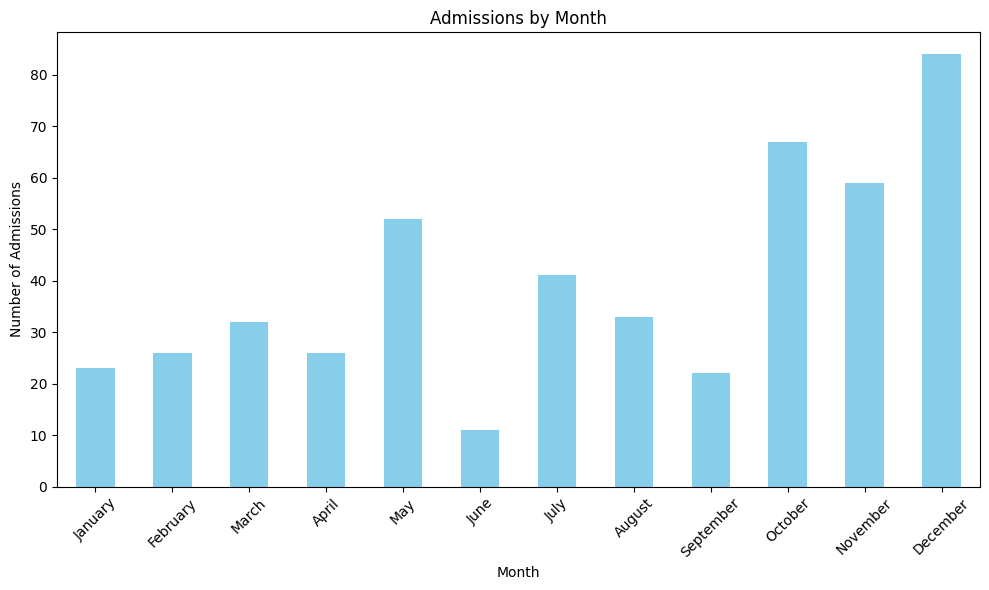

In [ ]:
print("Number of entries in the dataframe:", patients_df.shape[0])

# Extract month from admittime
print(type(patients_df['admittime']))
patients_df['admittimedate'] = pd.to_datetime(patients_df['admittime'])

# Extract the month and create 'admittime_month' column
patients_df['admittime_month'] = patients_df['admittimedate'].dt.month_name() # Create the column with month names

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert month to categorical data with specified order
patients_df['admittime_month'] = pd.Categorical(patients_df['admittime_month'], categories=month_order, ordered=True)

# Plot histogram sorted by month
plt.figure(figsize=(10, 6))
patients_df['admittime_month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Admissions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

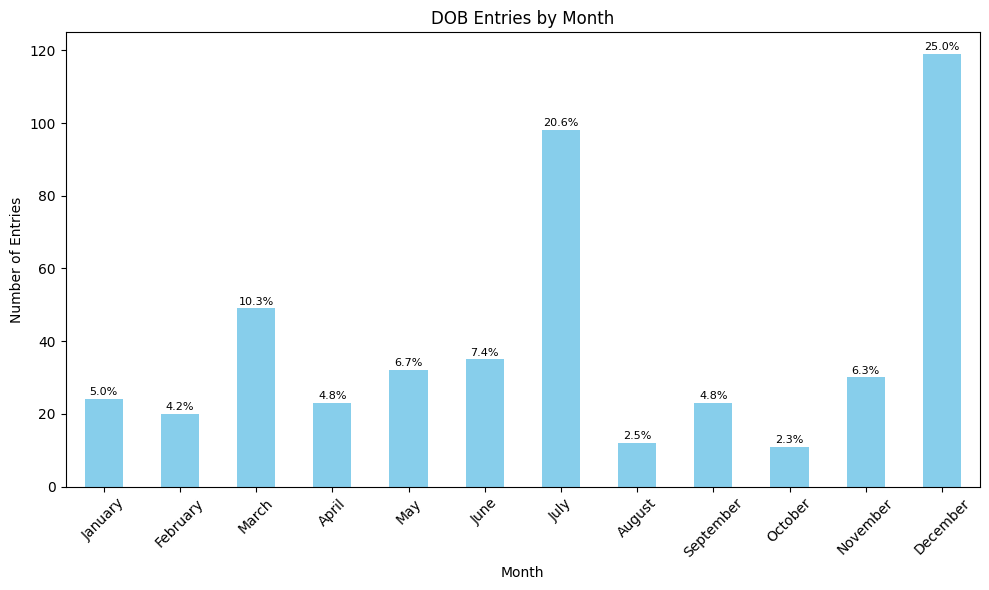

In [ ]:
# since 'dob' is not in datetime format, convert it first
patients_df['dobdatetime'] = pd.to_datetime(patients_df['dob'])

# Extract month from dob
patients_df['dob_month'] = patients_df['dobdatetime'].dt.month_name()

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert month to categorical data with specified order
patients_df['dob_month'] = pd.Categorical(patients_df['dob_month'], categories=month_order, ordered=True)

# Count the number of entries for each month
entries_per_month = patients_df['dob_month'].value_counts().sort_index()

# Calculate the percentage of entries for each month
percentage_per_month = entries_per_month / len(patients_df) * 100

# Plot histogram sorted by month
plt.figure(figsize=(10, 6))
ax = entries_per_month.plot(kind='bar', color='skyblue')

# Annotate each bar with the corresponding percentage
for i, v in enumerate(percentage_per_month):
    ax.text(i, entries_per_month[i] + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

plt.title('DOB Entries by Month')
plt.xlabel('Month')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


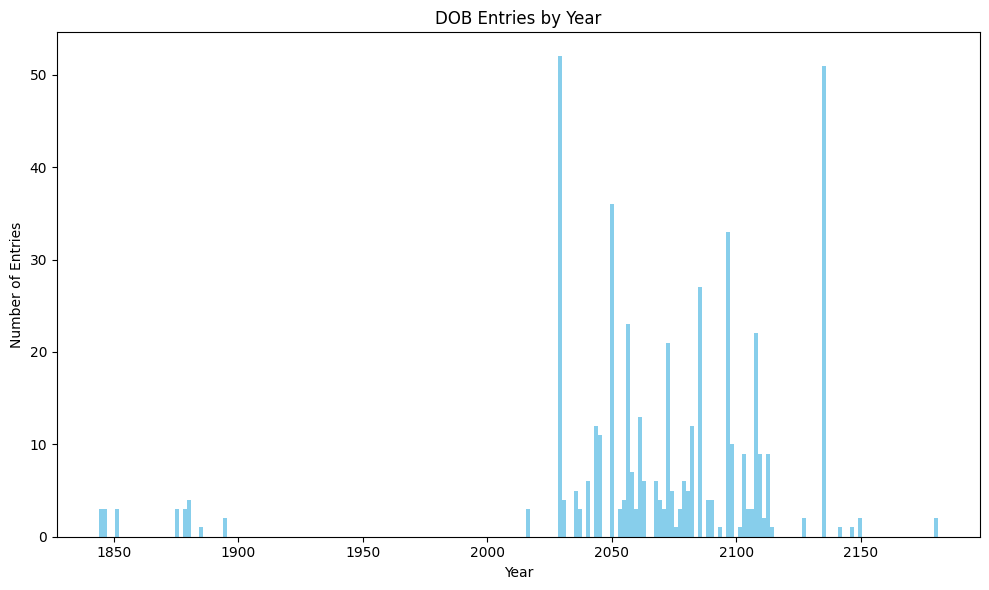

In [ ]:
# Extract year from dobdatetime
patients_df['dob_year'] = patients_df['dobdatetime'].dt.year

# Plot histogram by year
plt.figure(figsize=(10, 6))
patients_df['dob_year'].plot(kind='hist', bins=210, color='skyblue')
plt.title('DOB Entries by Year')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()